# Fingerprint Recognition using CNN and Keras

Fingerprint recognition tasks typically fall into one of two categories:

- **Fingerprint Verification (1:1 matching)** — *"Is this the claimed person?"*  
  This is a one-to-one comparison between a captured fingerprint and a stored template.  
  **Example:** unlocking a smartphone using your fingerprint.

- **Fingerprint Identification (1:K matching)** — *"Who is this person?"*  
  This involves comparing a fingerprint against a database of templates to find a match.  
  **Example:** allowing employees to enter a building by scanning their fingerprint instead of using an ID badge.


## Table of Contents

- [1 - Packages](#1---Packages)
- [2 - Parameters](#2---Parameters)
- [3 - Load Dataset](#3---Load-Dataset)
    - [3.1 - Visualize](#3.1---Visualize)
- [4 - Train–Validation Split](#4---Train-Validation-Split)
    - [4.1 - Data Augmentation](#4.1---Data-Augmentation)
- [5 - Siamese Networks](#5---Siamese-Networks)
    - [5.1 - Custom Data Generator for Fingerprint Matching](#5.1---Custom-Data-Generator-for-Fingerprint-Matching)
    - [5.2 - Setting Up the Siamese Embedding Model](#5.2---Setting-Up-the-Siamese-Embedding-Model)
        - [5.2.1 - Model Plotting](#5.2.1---Model-Plotting)
- [6 - Training the Siamese Network](#6---Training-the-Siamese-Network)
- [7 - Model Evaluation with Sample Fingerprints](#7---Model-Evaluation-with-Sample-Fingerprints)
- [8 - References](#8---References)

<a name='1'></a>
## 1 - Packages

In [1]:
import numpy as np

import matplotlib.pyplot as plt
import keras
from keras import layers, Model, Input
from keras.utils import plot_model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa

import random

2025-07-15 12:06:20.209775: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a name='2'></a>

## 2 - Parameters

In [2]:
image_size = 90
tags = ['real', 'easy', 'medium', 'hard']

<a name='3'></a>

## 3 - Load Dataset

Load grayscale fingerprint images and their associated labels from .npy files.

Each label contains:
 - **Subject ID**
 - **Gender** (0 = Male, 1 = Female)
 - **Side** (0 = Left, 1 = Right)
 - **Finger Type** (0–4 = Thumb to Little)


In [3]:
x_data = {}
y_data = {}

for tag in tags:
    x_data[tag] = np.load(f'dataset/processed/x_{tag}.npy')
    y_data[tag] = np.load(f'dataset/processed/y_{tag}.npy')
    print(f"{tag}: imgs.shape: {x_data[tag].shape}, labels.shape: {y_data[tag].shape}")

real: imgs.shape: (6000, 96, 96), labels.shape: (6000, 4)
easy: imgs.shape: (17931, 96, 96), labels.shape: (17931, 4)
medium: imgs.shape: (17067, 96, 96), labels.shape: (17067, 4)
hard: imgs.shape: (14272, 96, 96), labels.shape: (14272, 4)


<a name='3.1'></a>
### 3.1 - Visualize

Display the first 4 fingerprint images from each selected category (`real`, `hard`) along with their respective labels.


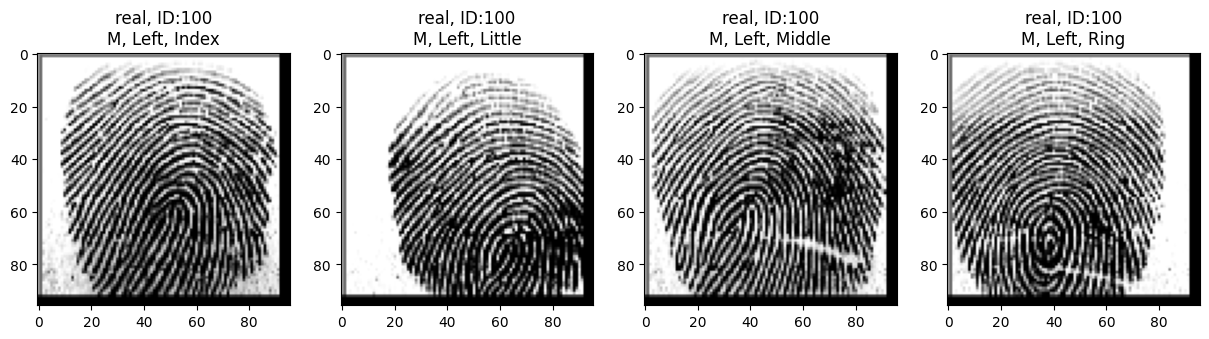

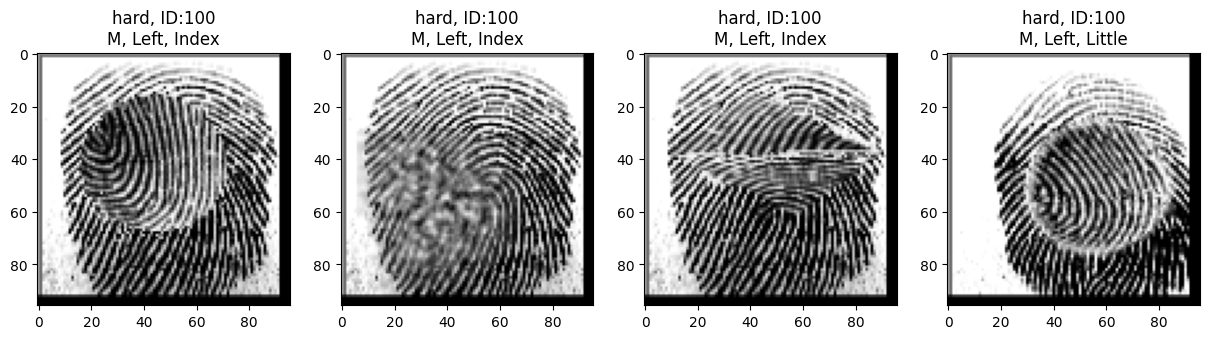

In [4]:
def visualize(tags):
    for tag in tags:
        plt.figure(figsize=(15, 5))
        for i in range(4):
            plt.subplot(1, 4, 1 + i)
            subject_id, gender, side, finger = y_data[tag][i]
            gender_str = 'M' if gender == 0 else 'F'
            side_str = 'Left' if side == 0 else 'Right'
            finger_str = ['Thumb', 'Index', 'Middle', 'Ring', 'Little'][finger]
        
            
            plt.title(f"{tag}, ID:{subject_id}\n{gender_str}, {side_str}, {finger_str}")
            plt.imshow(x_data[tag][i], cmap='gray')

visualize(['real','hard'])

<a name='4'></a>
## 4 - Train-Validation Split

We combine all altered fingerprint images — Easy, Medium, and Hard — into a single dataset, then perform a 90/10 train–validation split.

This split allows us to train on a diverse set of altered fingerprints while holding out a portion for validation to assess model generalization.

In [5]:
x_data_concat = np.concatenate([x_data["easy"], x_data["medium"], x_data["hard"]], axis=0)
label_data_concat = np.concatenate([y_data["easy"], y_data["medium"], y_data["hard"]], axis=0)

x_train, x_val, label_train, label_val = train_test_split(
    x_data_concat, label_data_concat, test_size=0.1, random_state=42, shuffle=True
)

print("Total dataset:", x_data_concat.shape, label_data_concat.shape)
print("Training set:", x_train.shape, label_train.shape)
print("Validation set:", x_val.shape, label_val.shape)

Total dataset: (49270, 96, 96) (49270, 4)
Training set: (44343, 96, 96) (44343, 4)
Validation set: (4927, 96, 96) (4927, 4)


<a name='4.1'></a>
## 4.1 - Data Augmentation

To make the model more robust to real-world variations in fingerprint images, we apply **data augmentation** during training. 

Fingerprint images can vary due to:
- Sensor noise
- Finger pressure or rotation
- Translation or scale shifts during scanning

To simulate these conditions and help the model generalize better, we apply a series of random augmentations to the training images in real-time using the `imgaug` library. These augmentations include:

- **Gaussian Blur**: Simulates low-quality or smudged scans.
- **Affine Transformations**:
  - **Scaling** (zoom in/out)
  - **Translation** (shifting the image horizontally or vertically)
  - **Rotation** (simulating angular variation of finger placement)
  - **Interpolation and fill handling** (with edge padding)

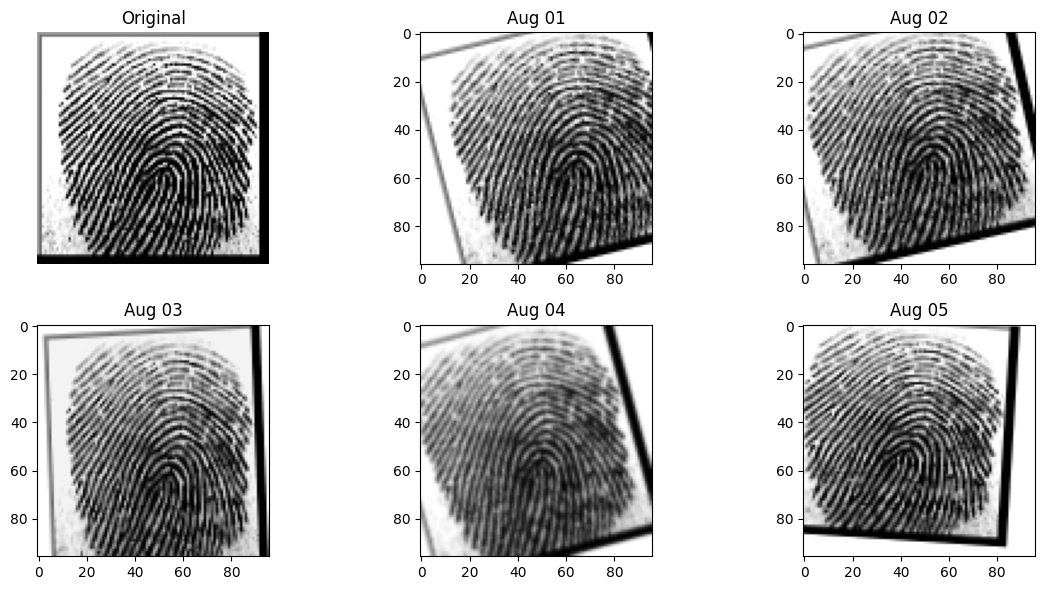

In [6]:
original_img = x_data['real'][0] # get a random image
augs = [original_img] * 5 # replicate it 5 times

# Define augmentation pipeline
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.1, 1.0))),
    iaa.Affine(
        scale = {"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent = {"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate = (-20, 20),
        shear = (-10, 10),
        order = 1,
        cval = 255,
        mode = "constant"
    ),
    iaa.Sometimes(0.3, iaa.LinearContrast((0.9, 1.1))),
    iaa.Sometimes(0.3, iaa.Add((-10, 10), per_channel=False)),
], random_order=True)

augs = seq.augment_images(augs)

plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
plt.title('Original')
plt.imshow(original_img.squeeze(), cmap='gray')
plt.axis('off')

for i, aug in enumerate(augs):
    plt.subplot(2, 3, i + 2)
    plt.title(f'Aug {i+1:02d}')
    plt.imshow(aug.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()

<a name='5'></a>
## 5 - Siamese Networks

To train a model that can determine whether two fingerprint images belong to the same individual, we need to feed it pairs of images and a corresponding match label:

- `1`: if the two fingerprints are from the **same person and finger**
- `0`: if they are from **different people or different fingers**

This setup is commonly used in **Siamese networks** or **contrastive learning**, where the model learns a similarity function rather than a direct classification. Figure 1 depicts an example of such a network.

<img src="images/siamese.excalidraw.png" >
<caption><center> <u> <b>Figure 1: Siamese Network</b> </u></center></caption>

<a name='5.1'></a>
### 5.1 - Custom Data Generator for Fingerprint Matching

Keras' default data loaders are designed for classification tasks, where each input corresponds to a single label. But in our case, we need to:

- Dynamically create **pairs of images** (altered vs. real)
- Provide a **binary match label** for each pair
- Apply **real-time augmentation** to improve robustness
- Efficiently handle large datasets without loading everything into memory


The next function, named `DataGenerator`, performs the following at each batch:

Steps
1. Selects a batch of altered fingerprints (`x_train` or `x_val`)
2. For each altered image, randomly selects a **matching or non-matching** fingerprint from the clean `x_data['real']` pool
3. Returns a pair of images (`[altered, real]`) along with a binary match label (`1.0` for same, `0.0` for different)
4. Applies **data augmentation**.


In [7]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, labels, x_real, y_real,
                 batch_size = 32, image_shape = (96, 96, 1), shuffle = True, augment = True):
        """
        Initialization
        """
        self.x = x
        self.labels = labels
        self.x_real = x_real
        self.label_real_dict = {}

        for i, y in enumerate(y_real):
            key = y.astype(str)
            key = ''.join(key).zfill(6)
        
            self.label_real_dict[key] = i

        self.batch_size = batch_size
        self.image_shape = image_shape
        self.shuffle = shuffle
        self.augment = augment

        self.on_epoch_end()
        self.augmenter = self._build_augmenter()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        """
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        """
        Generate one batch of data
        """
        x1_batch = self.x[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch = self.labels[index * self.batch_size : (index + 1) * self.batch_size]

        # Apply augmentation only during training
        if self.shuffle and self.augment:
            x1_batch = self.augmenter.augment_images(x1_batch)

        # Prepare output arrays
        x2_batch = np.empty((self.batch_size, * self.image_shape), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)

        for i, label in enumerate(label_batch):
            match_key = self._get_match_key(label)

            if random.random() > 0.5:
                # Matched image
                img = self.x_real[self.label_real_dict[match_key]]
                x2_batch[i] = np.expand_dims(img, axis=-1)
                y_batch[i] = 1.0
            else:
                # Unmatched image
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                    if unmatch_key != match_key:
                        img = self.x_real[unmatch_idx]
                        x2_batch[i] = np.expand_dims(img, axis=-1)
                        break
                y_batch[i] = 0.0

        # Normalize to [0, 1]
        x1_batch = x1_batch.astype(np.float32) / 255.0
        x2_batch = x2_batch.astype(np.float32) / 255.0

        return (x1_batch, x2_batch), y_batch

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        """
        if self.shuffle:
            self.x, self.labels = shuffle(self.x, self.labels)

    def _get_match_key(self, label):
        """
        Convert label array to string key, e.g. [015, 1, 1, 0] → '015110'
        """
        return ''.join(label.astype(str)).zfill(6)

    def _build_augmenter(self):
        """
        Build the augmentation pipeline
        """
        return iaa.Sequential([
            iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0.1, 1.0))),
            iaa.Affine(
                scale = {"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent = {"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate = (-20, 20),
                shear = (-10, 10),
                order = 1,
                cval = 255,
                mode = "constant"
            ),
            iaa.Sometimes(0.3, iaa.LinearContrast((0.85, 1.15))),
            iaa.Sometimes(0.3, iaa.Add((-10, 10), per_channel=False)),
        ], random_order=True)

In [8]:
# Generate train and validation batch splits

train_gen = DataGenerator(x_train, label_train, x_data['real'], y_data['real'], shuffle = True)
val_gen = DataGenerator(x_val, label_val, x_data['real'],  y_data['real'], shuffle = False)

<a name='5.2'></a>
### 5.2 - Setting Up the Siamese Embedding Model

To compare fingerprint pairs, we build a Siamese network that learns to generate compact **embeddings** (vector representations) for each image. These embeddings are then compared using a distance function, allowing the model to predict whether two fingerprints belong to the same identity.

Our embedding generator is a shared CNN (shared weights for both images), which maps each input fingerprint to a 128-dimensional embedding vector. We then compute the L1 distance (absolute difference) between the two embeddings and feed the result into a small feedforward network to produce a similarity score (between 0 and 1).

Below is the definition of the Siamese network architecture:


In [9]:
x1 = Input(shape = (image_size, image_size, 1), name='input_image_1')
x2 = Input(shape = (image_size, image_size, 1), name='input_image_2')

# Shared embedding network
def build_embedding_model(input_shape = (image_size, image_size, 1)):
    inputs = Input(shape = input_shape)

    x = layers.Conv2D(32, kernel_size = 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    x = layers.Conv2D(32, kernel_size = 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    x = layers.Conv2D(64, kernel_size = 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(pool_size = 2)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)  # Final embedding
    return Model(inputs, x, name='embedding_model')

# Create shared embedding model
embedding_model = build_embedding_model()

# Get embeddings for both inputs
embedding_1 = embedding_model(x1)
embedding_2 = embedding_model(x2)

# Compute L1 distance between embeddings
distance = layers.Lambda(lambda tensors: abs(tensors[0] - tensors[1]), name='L1_distance')([embedding_1, embedding_2])

# Fully connected layers for binary classification
x = layers.Dense(64, activation='relu')(distance)
output = layers.Dense(1, activation='sigmoid')(x)

# Final Siamese model
model = Model(inputs=[x1, x2], outputs=output, name='siamese_model')

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image_1       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_image_2       │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 128)       │  1,207,840 │ input_image_1[0]… │
│ (Functional)        │                   │            │ input_image_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ L1_distance         │ (None, 128)       │          0 │ embedding_model[… │
│ (Lambda)            │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ L1_distance[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,216,161 (4.64 MB)

 Trainable params: 1,216,161 (4.64 MB)

 Non-trainable params: 0 (0.00 B)

<a name='5.2.1'></a>
### 5.2.1 - Model Plotting

We can also use `keras.util.plot_model()` to plot our CNN.

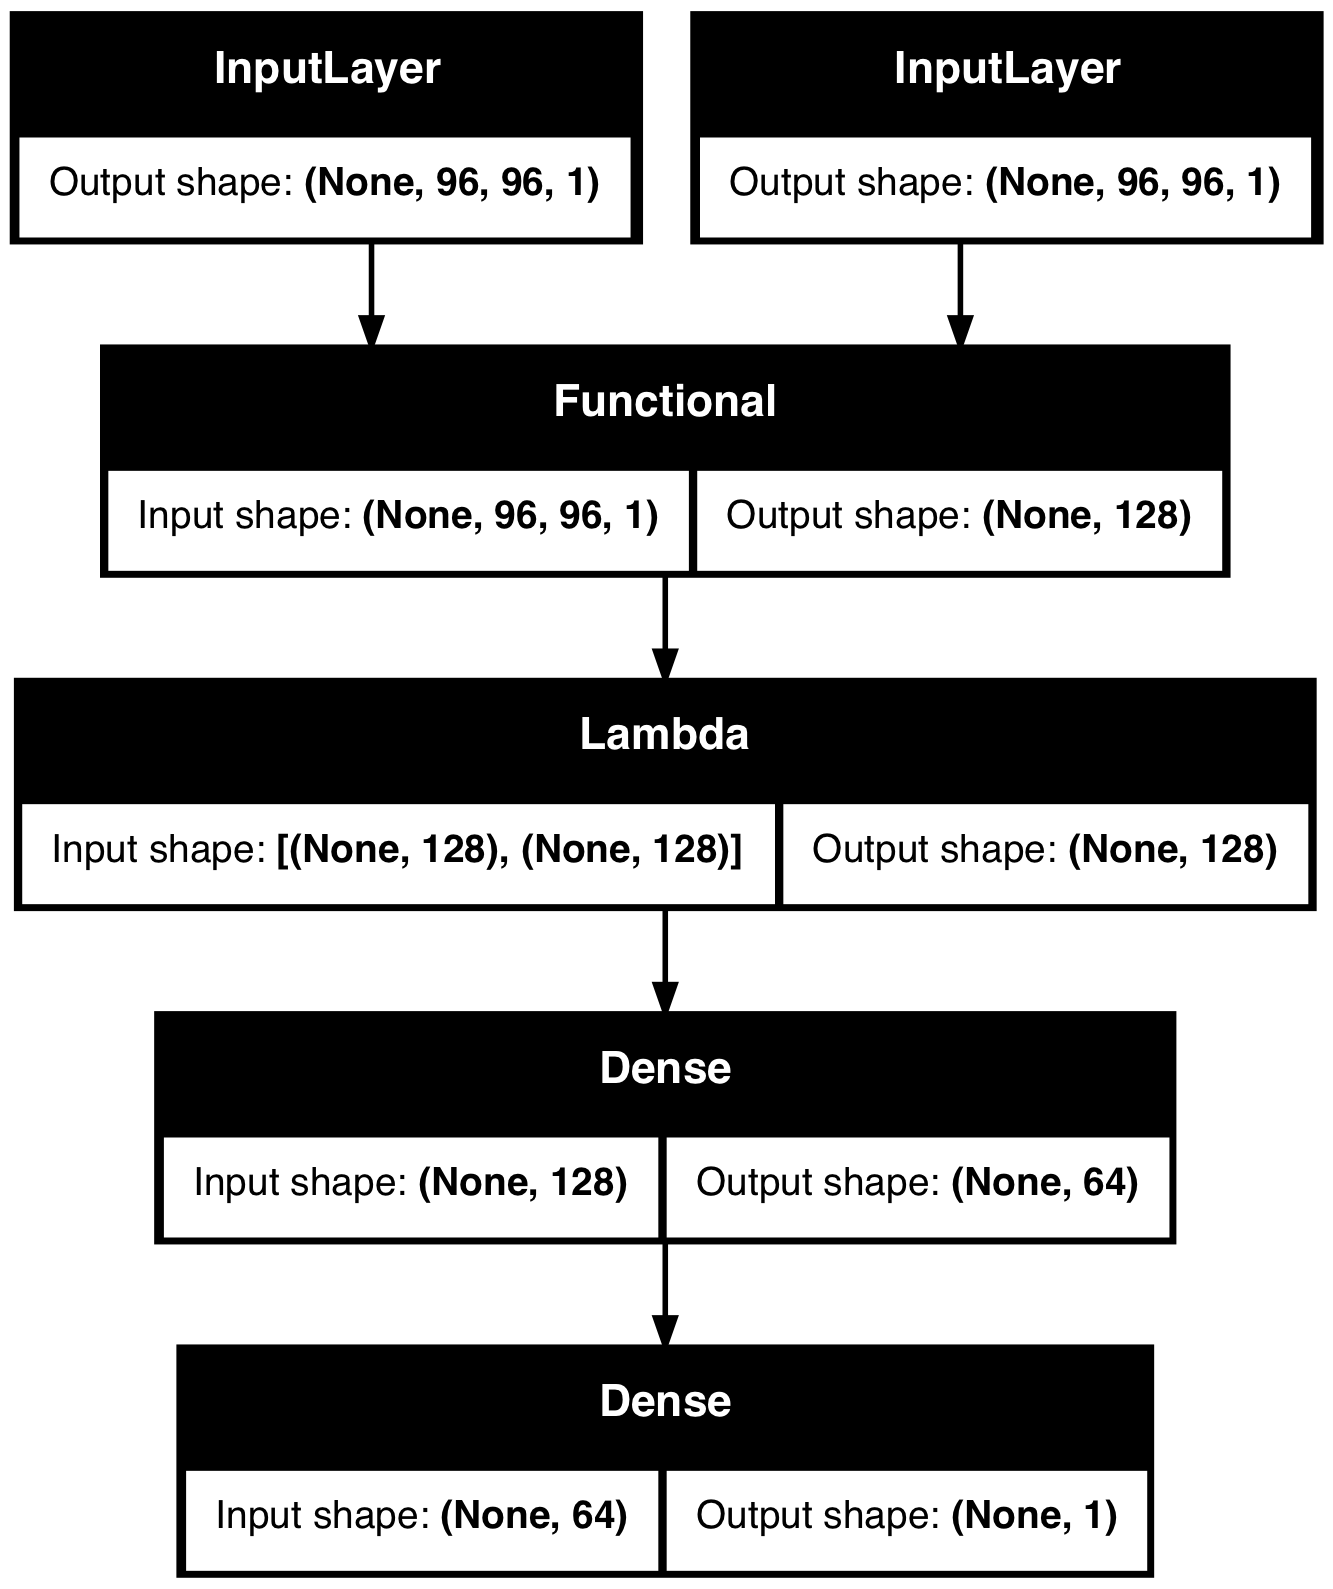

In [10]:
plot_model(model, show_shapes = True, to_file='./images/model.png')

<a name='6'></a>
## 6 - Training the Siamese Network

We now train the Siamese model using the fingerprint pairs generated by our custom `DataGenerator`. The generator provides batches of image pairs (`x1`, `x2`) along with binary labels (`1` for matching fingerprints, `0` for mismatched ones). 

During training, the model learns to map each fingerprint to a meaningful embedding vector, such that the embeddings of matching fingerprints are closer together than those of mismatched ones.

We train the model for one epoch initially to validate the training setup and ensure the data pipeline and architecture are functioning as expected.


In [11]:
history = model.fit(train_gen, epochs = 2, validation_data = val_gen)

/usr/local/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 541s 388ms/step - accuracy: 0.8639 - loss: 0.3082 - val_accuracy: 0.7396 - val_loss: 0.4963
Epoch 2/2
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 537s 388ms/step - accuracy: 0.9527 - loss: 0.1273 - val_accuracy: 0.6865 - val_loss: 0.5806


<a name='7'></a>
## 7 - Model Evaluation with Sample Fingerprints

In this evaluation phase, we simulate a real-world use case: given a new fingerprint (e.g., from a user trying to authenticate), the model compares it against a known fingerprint to decide if it's a match.

- We randomly select one fingerprint from the validation set (`random_img`) and slightly augment it to simulate natural variations (e.g., rotation, scale, or noise).
- We then:
  - Compare it with the **correct match** from the real dataset (same identity and finger).
  - Compare it with a **random unmatched** fingerprint from a different identity.
- The Siamese model produces a prediction score between 0 and 1:
  - Closer to **1** means a higher likelihood of a match.
  - Closer to **0** means a mismatch.

The predictions and images are visualized side-by-side to help interpret model behavior.


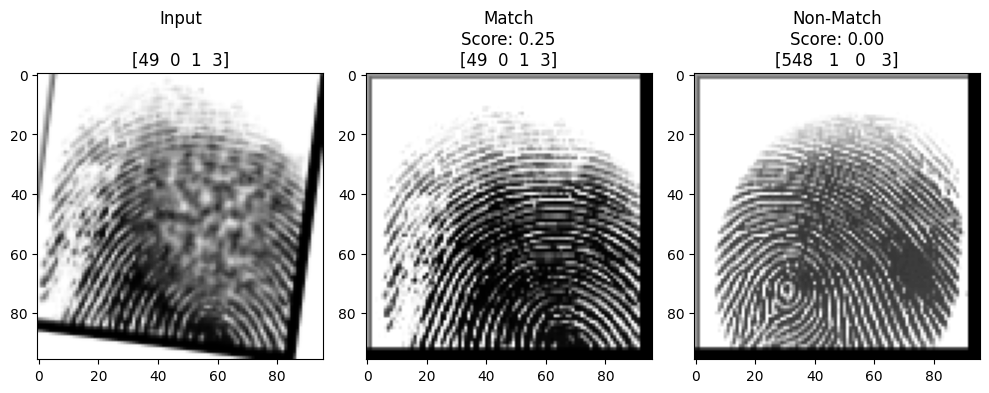

<Figure size 640x480 with 0 Axes>

In [16]:
# Create a dictionary for real fingerprint labels to index mapping
label_dict = {
    ''.join(label.astype(str)).zfill(6): i
    for i, label in enumerate(y_data['real'])
}

# Select a random fingerprint from validation set and apply augmentation
random_idx = random.randint(0, len(x_val) - 1)
random_img = x_val[random_idx]
random_label = label_val[random_idx]

# Augment the fingerprint
augment_seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 0.5)),
    iaa.Affine(
        scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        rotate=(-30, 30),
        order=[0, 1],
        cval=255
    )
], random_order=True)

aug_img = augment_seq.augment_image(random_img).reshape(1, image_size, image_size, 1).astype(np.float32) / 255.

# Get matching fingerprint from real dataset
match_key = ''.join(random_label.astype(str)).zfill(6)
rx = x_data['real'][label_dict[match_key]].reshape(1, image_size, image_size, 1).astype(np.float32) / 255.
ry = y_data['real'][label_dict[match_key]]

# Predict match
pred_rx = model.predict([aug_img, rx], verbose=0)[0][0]

# Get a non-matching fingerprint
while True:
    unmatch_key, unmatch_idx = random.choice(list(label_dict.items()))
    if unmatch_key != match_key:
        break

ux = x_data['real'][unmatch_idx].reshape(1, image_size, image_size, 1).astype(np.float32) / 255.
uy = y_data['real'][unmatch_idx]

# Predict non-match
pred_ux = model.predict([aug_img, ux], verbose=0)[0][0]

# Plot the results
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.title(f'Input\n\n{random_label}')
plt.imshow(aug_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f'Match\nScore: {pred_rx:.2f}\n{ry}')
plt.imshow(rx.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title(f'Non-Match\nScore: {pred_ux:.2f}\n{uy}')
plt.imshow(ux.squeeze(), cmap='gray')

plt.tight_layout()
plt.show()
plt.savefig('images/result.png', bbox_inches='tight')

<a name='8'></a>
## 8 - References

Some of the ideas and code structure in this notebook were adapted or inspired by the following resources:

- [Kairess' Fingerprint Recognition GitHub Repository](https://github.com/kairess/fingerprint_recognition)  
  A practical implementation of fingerprint matching using a Siamese network trained on the SOCOFing dataset.

- Koch et al. (2015), *"Siamese Neural Networks for One-shot Image Recognition"*  
  Introduced the Siamese network architecture for comparing image embeddings in low-data regimes. [(paper link)](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)

- [SOCOFing Dataset on Kaggle](https://www.kaggle.com/datasets/ruizgara/socofing)  
  A fingerprint dataset including both real and synthetically altered samples used in this notebook.

- [Image Similarity Estimation Using a Siamese Network with a Triplet Loss](https://keras.io/examples/vision/siamese_network/)  
  Example by Hazem Essam and Santiago L. Valdarrama (2021) showing how to train a Siamese network using triplet loss in Keras.
